### Julia SIFT Implementation

Based on [PythonSIFT](https://github.com/rmislam/PythonSIFT)

In [1]:
import Images
import MosaicViews.mosaicview
import Random

# import TestImages
# import Plots
# import IJulia

In [2]:
Images.ImageFiltering

ImageFiltering

Testing Image "Cameraman"

In [3]:
# org  = TestImages.testimage("cameraman")
org = Images.load("./cameraman.tif");
size(org)

(256, 256)

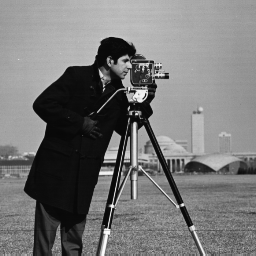

In [4]:
org

### Pipeline Functions

In [5]:
function compute_number_of_octaves( img::Matrix )
    img_size = size(img)
    return ceil(Int8, (round(log(minimum(img_size))) / log(2) - 1))
end
methods(compute_number_of_octaves)

# 1 method for generic function "compute_number_of_octaves":
[1] compute_number_of_octaves(img::Matrix) in Main at /home/mccastles/Workspace/AGICortex/JuliaSIFT/JuliaSIFT.ipynb:1

In [6]:
"""Prepare the first image of the pyramid."""
function generate_base_img( img::Matrix, σ::AbstractFloat, assumed_σ::AbstractFloat )
    app = Images.imresize( img, ratio=2 )
    σ_diff = sqrt((σ^2) - (2*assumed_σ)^2)
    σ_diff = maximum( (σ_diff, 0.1) )
    gauss = Images.ImageFiltering.Kernel.gaussian(σ_diff)
    app = Images.ImageFiltering.imfilter( app, gauss )
    return app    
end
methods(generate_base_img)

# 1 method for generic function "generate_base_img":
[1] generate_base_img(img::Matrix, σ::AbstractFloat, assumed_σ::AbstractFloat) in Main at /home/mccastles/Workspace/AGICortex/JuliaSIFT/JuliaSIFT.ipynb:2

In [7]:
"""Generate sigma parameters for Gaussian kernels,
applied to the images of the octave."""
function generate_gauss_kernels(
        σ::AbstractFloat,
        n_intervals::Integer )

    n_images_per_octave = n_intervals + 3
    k = 2 ^ (1.0 / n_intervals)
    gaussian_kernels = zeros(n_images_per_octave)
    gaussian_kernels[1] = σ

    for image_index in 2:n_images_per_octave

    σ_prev = (k ^ (image_index-2)) * σ
    σ_total = k *  σ_prev
        gaussian_kernels[ image_index ] = sqrt( σ_total^2 - σ_prev^2)
    end
    return gaussian_kernels

end
methods( generate_gauss_kernels )

# 1 method for generic function "generate_gauss_kernels":
[1] generate_gauss_kernels(σ::AbstractFloat, n_intervals::Integer) in Main at /home/mccastles/Workspace/AGICortex/JuliaSIFT/JuliaSIFT.ipynb:3

In [8]:
"""Blur and downsample images, to make a Gaussian pyramid"""
function generate_gauss_pyramid(
        base_image::AbstractMatrix,
        n_octaves::Integer,
        gaussian_kernels::AbstractVector)

    # Structure definitions
    TYPE_IMG = typeof(base_image)
    TYPE_OCTAVE = Vector{TYPE_IMG}

    octave = Vector{TYPE_IMG}()
    gauss_pyramid = Vector{TYPE_OCTAVE}([])

    # The first image of the first octave
    push!(octave, base_image)
    img = base_image
    size(img)

    for _ = 1:n_octaves
        # Applying the Gaussian filter for the octave
        for σ = gaussian_kernels[2:end]
            kernel = Images.ImageFiltering.Kernel.gaussian( σ )
            img = Images.ImageFiltering.imfilter( img, kernel )
            push!(octave, img)
        end
        
        # Storing the octaves
        print( "$(size(img)) ➡ " )
        push!(gauss_pyramid, octave)
        octave_base = octave[end-2]

        # Downsampling
        img = Images.imresize( octave_base, ratio=0.5 )
        octave = Vector{TYPE_IMG}([img])
    end
    return gauss_pyramid
end
methods(generate_gauss_pyramid)

# 1 method for generic function "generate_gauss_pyramid":
[1] generate_gauss_pyramid(base_image::AbstractMatrix, n_octaves::Integer, gaussian_kernels::AbstractVector) in Main at /home/mccastles/Workspace/AGICortex/JuliaSIFT/JuliaSIFT.ipynb:2

In [63]:
"""Calculate difference of Gauss for every octave"""
function generate_DoG_images(
        gauss_pyramid::AbstractVector)

    dogs_gauss_pyramid = similar(gauss_pyramid, 0)
    for octave in gauss_pyramid
        dog_octave = similar(octave, 0)
        for i = 2:length(octave)
            # dog = normalize_matrix(Float64.(octave[i]) - Float64.(octave[i-1]))
            dog = Float64.(octave[i]) - Float64.(octave[i-1])
            push!(dog_octave, dog)
        end
        push!( dogs_gauss_pyramid, dog_octave )
    end
    return dogs_gauss_pyramid
end
methods(generate_DoG_images)

# 1 method for generic function "generate_DoG_images":
[1] generate_DoG_images(gauss_pyramid::AbstractVector) in Main at /home/mccastles/Workspace/AGICortex/JuliaSIFT/JuliaSIFT.ipynb:2

In [64]:
function find_scale_space_extrema( gauss_pyramid, dogs_pyramid, n_intervals, σ, img_border_width )
    
end

find_scale_space_extrema (generic function with 1 method)

### Helping Functions

In [65]:

# Normalize the matrix
function normalize_matrix( m::AbstractMatrix )
    return (m.-minimum(m)) ./ (maximum(m)-minimum(m))
end


# Normalize the matrix and make it an image
function matrix2img( m::AbstractMatrix )
    return Array{Images.ColorTypes.Gray{Float64}, 2}(normalize_matrix(m))
end


matrix2img (generic function with 1 method)

### Pipeline

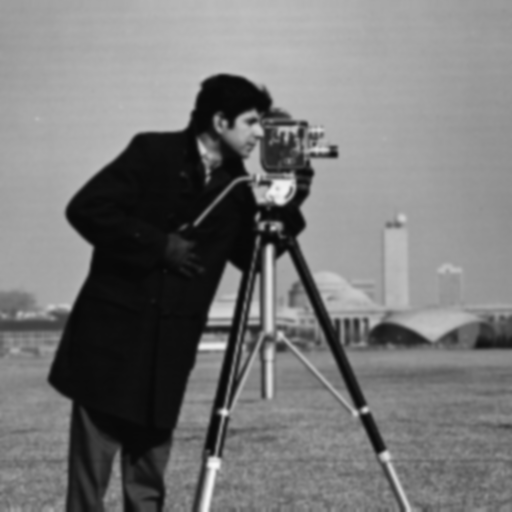

In [66]:
σ = 1.6
assumed_σ = 0.5
base_img = generate_base_img(org, σ, assumed_σ)

In [67]:
n_octaves = compute_number_of_octaves( base_img )

8

In [68]:
n_intervals = 3

gaussian_kernels = generate_gauss_kernels( σ, n_intervals )
gaussian_kernels

6-element Vector{Float64}:
 1.6
 1.2262734984654078
 1.5450077936447955
 1.9465878414647133
 2.4525469969308156
 3.0900155872895927

In [69]:
# Demonstration
# Each octave increases the total blur twice: 1.6, 3.2, ...
conv = function ( σ₁, σ₂ ) return sqrt( σ₁^2 + σ₂^2 ) end
current_blur = gaussian_kernels[1]
for s in gaussian_kernels[2:end-2]
    current_blur = conv(current_blur, s)
    println( "Total Blur: $current_blur" )
end

Total Blur: 2.015873679831797
Total Blur: 2.539841683149119
Total Blur: 3.2


(512, 512) ➡ (256, 256) ➡ (128, 128) ➡ (64, 64) ➡ (32, 32) ➡ (16, 16) ➡ (8, 8) ➡ (4, 4) ➡ 

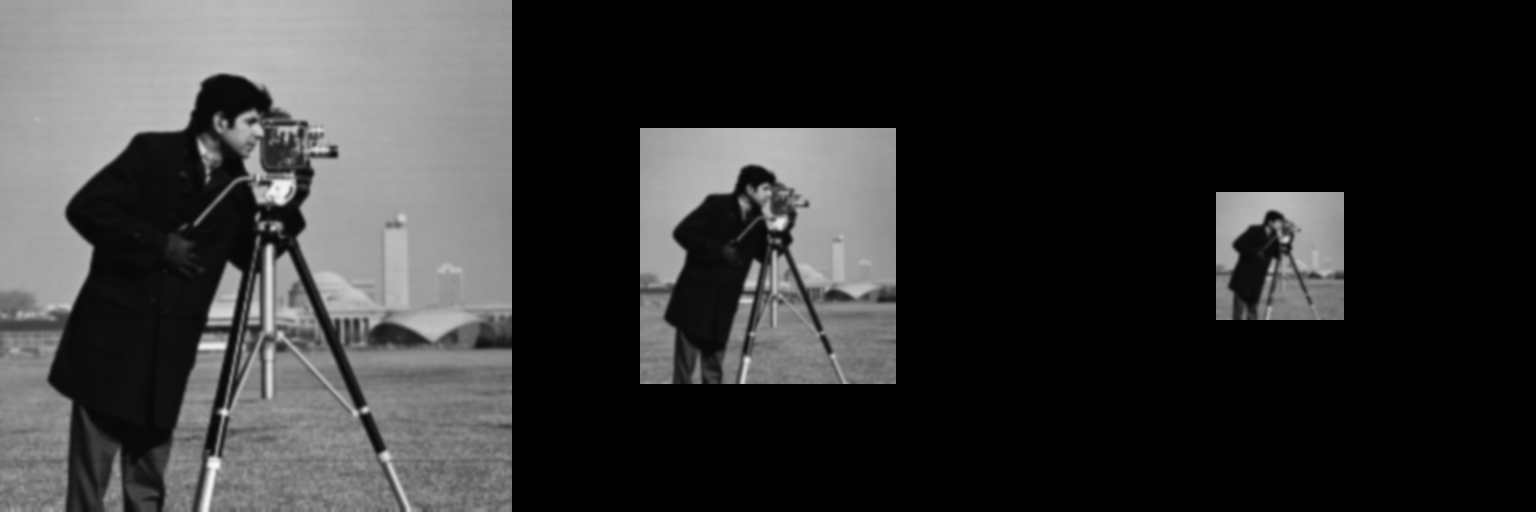

In [70]:
gauss_pyramid = generate_gauss_pyramid(base_img, n_octaves, gaussian_kernels)

ladder = [gauss_pyramid[i][1] for i=1:3]
mosaicview(ladder[1:3], ncol=3)

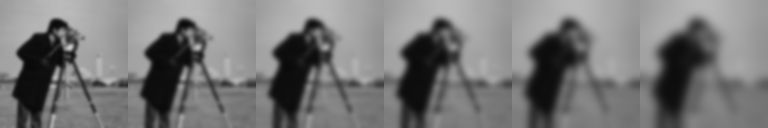

In [71]:
mosaicview(gauss_pyramid[3], ncol=length(gauss_pyramid[end]))

In [72]:
dog_pyramid = generate_DoG_images( gauss_pyramid )
size(dog_pyramid)

(8,)

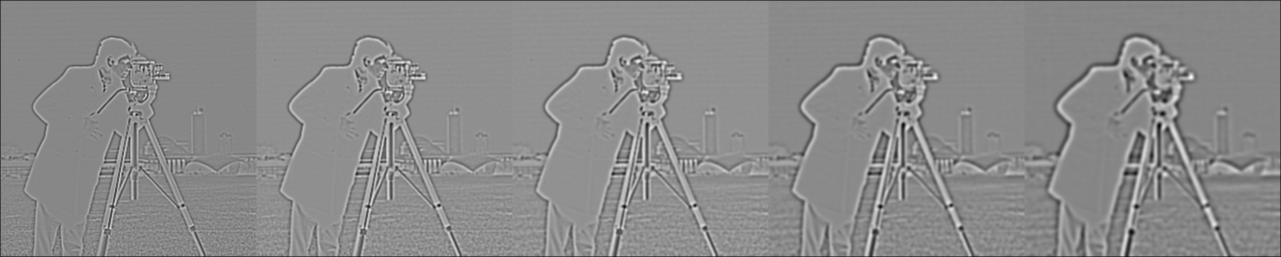

In [90]:
mosaicview(normalize_matrix.(dog_pyramid[1]), ncol=length(dog_pyramid[1]) )

In [74]:
img_border_width = 5
# keypoints = find_scale_space_extrema( gauss_pyramid, dogs_pyramid, n_intervals, σ, img_border_width)

5

### Experiments

In [91]:
keypoints = Vector([])

Any[]

In [92]:
contrast_threshold = 0.04
th = floor( 0.5 * contrast_threshold / n_intervals * 255 ) / 255

0.00392156862745098

In [104]:
"""Produces a 3x3 neighbourhood around a pixel."""
function subimg(img, i, j)
    return img[i-1:i+1, j-1:j+1]
end


"""Checks if a center pixel of a cube is a local extremum."""
function center_pixel_is_extremum( cube::AbstractArray, threshold::AbstractFloat )
    center_pixel_value = cube[2, 2, 2]
    if abs(center_pixel_value) > threshold
        if center_pixel_value > 0
            return sum(center_pixel_value .>= cube) == 27
        else
            return sum(center_pixel_value .<= cube) == 27
        end
    end
    return false
end



"""Produces a cube from thre three neighbouring images"""
function make_pixel_cube(
        first_img::AbstractMatrix, second_img::AbstractMatrix, third_img::AbstractMatrix, i::Integer, j::Integer)
    cube = zeros(Float64, (3,3,3))
    cube[:,:,1] = subimg( first_img, i, j )
    cube[:,:,2] = subimg( second_img, i, j )
    cube[:,:,3] = subimg( third_img, i, j )
    return cube
end

make_pixel_cube

In [122]:
i  = 85
j = 204
octave_i = 1
central_img_i = 2

img_size = size(dog_pyramid[octave_i][1])

cube = make_pixel_cube(
    dog_pyramid[octave_i][central_img_i-1],
    dog_pyramid[octave_i][central_img_i],
    dog_pyramid[octave_i][central_img_i+1],
    85, 204 )

3×3×3 Array{Float64, 3}:
[:, :, 1] =
 0.0373115  0.0454835  0.0415009
 0.0413192  0.0454625  0.0357851
 0.0356919  0.039925   0.0294703

[:, :, 2] =
 0.0332588  0.0447045  0.0473632
 0.038798   0.0476937  0.0456414
 0.0349584  0.0434702  0.0399792

[:, :, 3] =
 0.0266032  0.0386999  0.0452326
 0.0311505  0.0423074  0.046252
 0.0292635  0.040031   0.0426813

In [120]:
center_pixel_is_extremum( cube, th )

true

In [ ]:
extremum_is_outside_image = false
eigenvalue_ratio=10
num_attempts_until_convergence=5

for attempt_index in 1:num_attempts_until_convergence

    gradient = gradient_at_central_pixel( cube )
    # hessian = hessian_at_central_pixel( cube )

end



In [127]:
"""Approximate the gradient at the central point."""
function gradient_at_central_pixel( cube )
    dx = 0.5 * (cube[2, 2, 3] - cube[2, 2, 1])
    dy = 0.5 * (cube[2, 3, 2] - cube[2, 1, 2])
    ds = 0.5 * (cube[3, 2, 2] - cube[1, 2, 2])
    return [dx, dy, ds]
end

function hessian_at_central_pixel( cube )
    center_pixel_value = cube[2, 2, 2]
    dxx = cube[2, 2, 3] - 2 * center_pixel_value + cube[2, 2, 1]
    dyy = cube[2, 3, 2] - 2 * center_pixel_value + cube[2, 1, 2]
    dss = cube[3, 2, 2] - 2 * center_pixel_value + cube[1, 2, 2]
    dxy = 0.25 * (cube[2, 3, 3] - cube[2, 3, 1] - cube[2, 1, 3] + cube[2, 1, 1])
    dxs = 0.25 * (cube[3, 2, 3] - cube[3, 2, 1] - cube[1, 2, 3] + cube[1, 2, 1])
    dys = 0.25 * (cube[3, 3, 2] - cube[3, 1, 2] - cube[1, 3, 2] + cube[1, 1, 2])
    
end


gradient_at_central_pixel (generic function with 1 method)

In [128]:
gradient_at_central_pixel(cube)

3-element Vector{Float64}:
 -0.0015775559961431485
  0.003421667221309946
 -0.0006171351058459201

In [106]:
function quadratic_fit( cube, i, j, central_img_i, octave_i, n_intervals, img_size, σ, th, img_border_width )
    return "Success"

    extremum_is_outside_image=false
    eigenvalue_ratio=10
    num_attempts_until_convergence=5


    for attempt_index in 1:num_attempts_until_convergence
        



        
    end
end

quadratic_fit (generic function with 1 method)

In [114]:

for (octave_i, dog_octave) in enumerate( dog_pyramid )
    println( octave_i )
    

    for dog_i in 3:length(dog_octave)

        println( '\t', (dog_i-2, dog_i-1, dog_i) )

        first_img = dog_octave[dog_i-2]
        second_img = dog_octave[dog_i-1]
        third_img = dog_octave[dog_i]

        height, width = size(first_img)
        for i in img_border_width:(height-img_border_width)
            for j in img_border_width:(width-img_border_width)

                # println(size(subimg(first_img, i, j)))
                # qqq( subimg(first_img), subimg(second_img), subimg(third_img), th )
                # pixel_is_extremum( subimg(first_img), subimg(second_img), subimg(third_img), th )
                # if pixel_is_extremum( subimg(first_img, i, j), subimg(second_img, i, j), subimg(third_img, i, j), th )
                
                # second_img = subimg(second_img, i, j)
                # second_img[2,2] = 999

                cube = make_pixel_cube( first_img, second_img, third_img, i, j )
                # println(cube)
                # break
                
                if center_pixel_is_extremum( cube, th )
                    println( "Extremum found" )
                    println( [octave_i, dog_i, i, j] )
                    # localization_result = quadratic_fit( cube, i, j, dog_i-1, octave_i, n_intervals, size(first_img), σ, th, img_border_width )
                    # println(localization_result)
                    # break

                end
                # break
            end
            # break
        end
        break

    end
    break
end    

1
	(1, 2, 3)
Extremum found
[1, 3, 85, 204]
Extremum found
[1, 3, 106, 275]
Extremum found
[1, 3, 110, 249]
Extremum found
[1, 3, 115, 283]
Extremum found
[1, 3, 116, 272]
Extremum found
[1, 3, 119, 217]
Extremum found
[1, 3, 124, 294]
Extremum found
[1, 3, 129, 282]
Extremum found
[1, 3, 129, 287]
Extremum found
[1, 3, 132, 301]
Extremum found
[1, 3, 134, 200]
Extremum found
[1, 3, 134, 262]
Extremum found
[1, 3, 136, 292]
Extremum found
[1, 3, 137, 138]
Extremum found
[1, 3, 142, 211]
Extremum found
[1, 3, 147, 125]
Extremum found
[1, 3, 148, 258]
Extremum found
[1, 3, 150, 317]
Extremum found
[1, 3, 152, 307]
Extremum found
[1, 3, 153, 244]
Extremum found
[1, 3, 154, 118]
Extremum found
[1, 3, 155, 313]
Extremum found
[1, 3, 157, 211]
Extremum found
[1, 3, 158, 200]
Extremum found
[1, 3, 158, 219]
Extremum found
[1, 3, 158, 241]
Extremum found
[1, 3, 169, 100]
Extremum found
[1, 3, 170, 106]
Extremum found
[1, 3, 174, 94]
Extremum found
[1, 3, 174, 312]
Extremum found
[1, 3, 178, 96